In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import time

from networks import *
from utils import *

import matplotlib.pyplot as plt

## Load Image and Prior

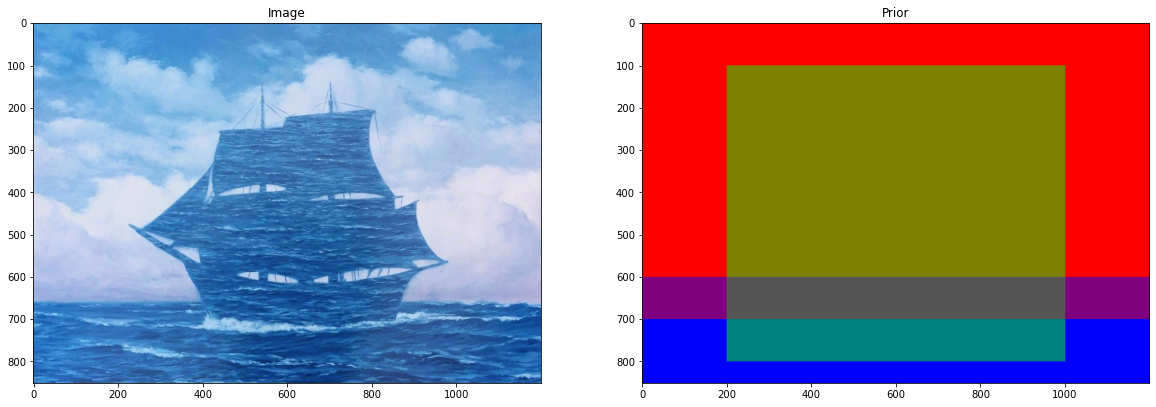

In [2]:
# Load image
seducer_path = 'img/seducer_v1.jpg'
seducer_array = np.asarray(Image.open(seducer_path))

# Load prior
prior_path = seducer_path.split('.')[0] + '_prior.png'
seducer_prior = np.asarray(Image.open(prior_path))

# Create torch tensor from arrays
img_tensor = torch.from_numpy(seducer_array.transpose([2,0,1]))
prior_tensor = torch.from_numpy(seducer_prior.transpose([2,0,1]))
prior_tensor = F.normalize(prior_tensor.float() + 0.2, p=1, dim=0)

fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(img_tensor.numpy().transpose([1,2,0]))
ax[0].set_title('Image')

ax[1].imshow(labels_to_color(prior_tensor.numpy(), False))
ax[1].set_title('Prior')

plt.show()

## Train Q Network

Iteration:    1 | Loss: 0.6328 | Elapsed: 0.03s
Iteration:  200 | Loss: 0.1491 | Elapsed: 5.28s


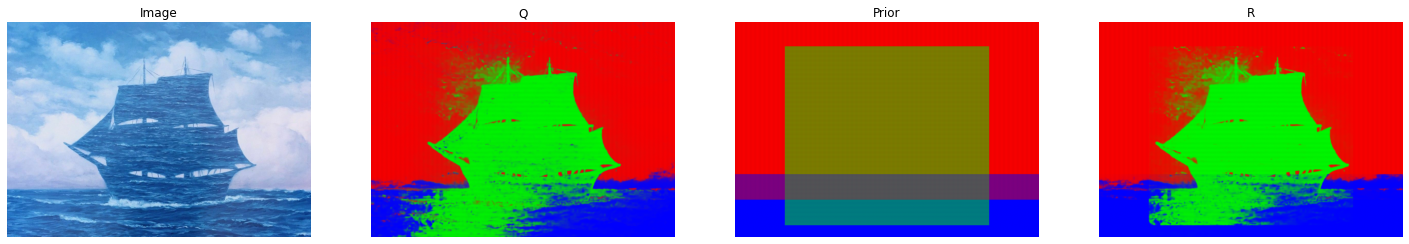

Iteration:  400 | Loss: 0.0402 | Elapsed: 11.71s


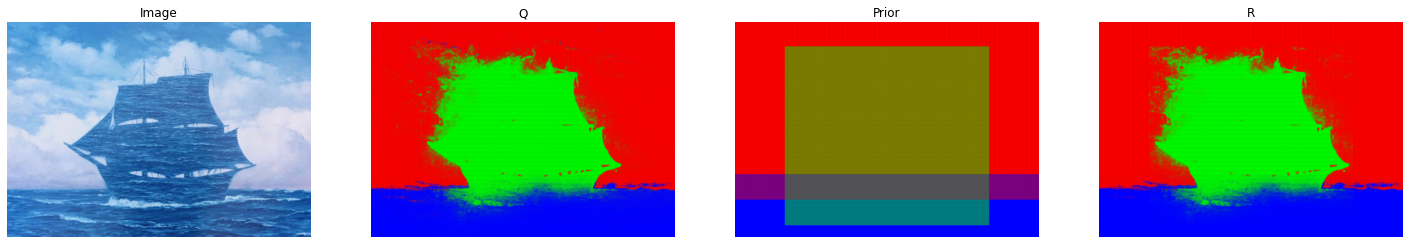

Iteration:  600 | Loss: 0.0114 | Elapsed: 18.25s


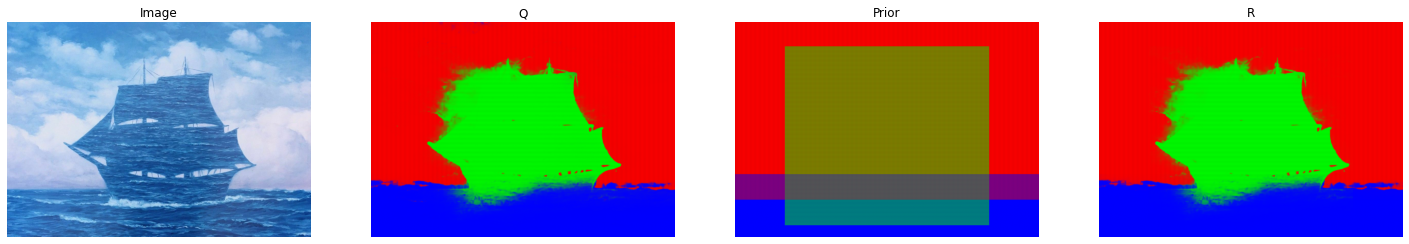

Iteration:  800 | Loss: 0.0073 | Elapsed: 24.71s


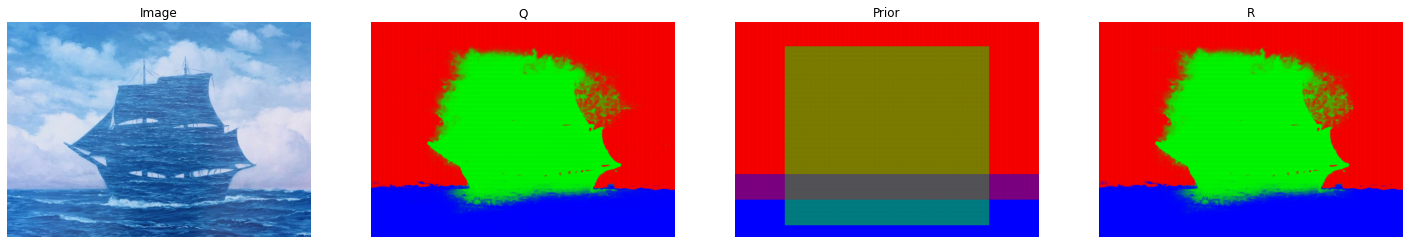

Iteration: 1000 | Loss: 0.0057 | Elapsed: 31.13s


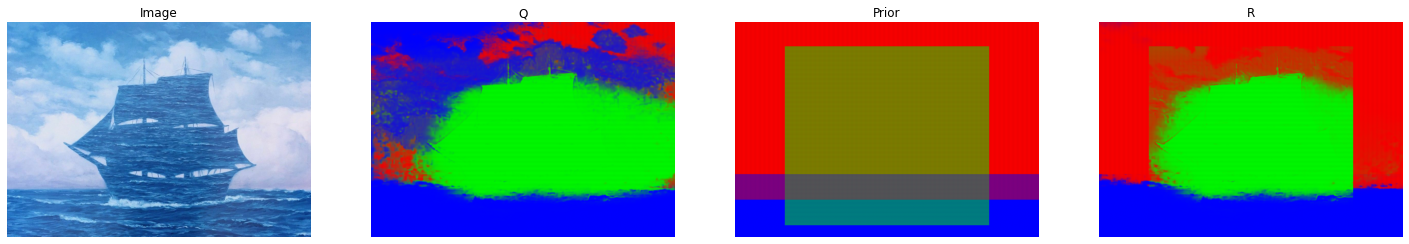

In [ ]:
# Setup training parameters
device = torch.device('cuda:0')
batch_size = 64
side = 64

iterations = 10000
show_every = 200

# Specify loss {loss_on_prior, loss_on_prior_reverse_kl}
loss = loss_on_prior_reverse_kl
losses = []

# Setup Q network
n_channels = 3
n_classes = len(seducer_labels)

net = FCN(n_channels, n_classes, conv_ch=32, pos_ch=4).to(device)        
opt = torch.optim.Adam(net.parameters(), lr=5e-4)
net.train()

# Added padding crop
crop = 5 

# Train
t1 = time.time()
for it in range(1, iterations + 1):  
    # Sample patches from image
    img_batch, prior_batch, pos_grid_batch = sample_from_img(
        img_tensor, prior_tensor, batch_size, side)

    # Create batch
    img_batch = (img_batch / 255.).float().to(device)
    pos_grid_batch = pos_grid_batch.float().to(device)
    prior_batch = prior_batch.float().to(device)
    target = F.normalize(prior_batch + 1e-6, p=1, dim=1)
    
    # Predict labels    
    pred_label_probs = net(img_batch, pos_grid_batch)
    pred_label_log_probs = torch.log(pred_label_probs)

    # Compute loss
    train_loss = loss(pred_label_log_probs[..., crop:-crop, crop:-crop], 
                      target[..., crop:-crop, crop:-crop])
        
    # Backwards step        
    opt.zero_grad()
    train_loss.backward()
    opt.step()

    # Log loss
    losses.append(train_loss.item())

    # Print loss
    if (it % 200) == 0 or it == 1:
        print(f'Iteration: {it:4d} | Loss: {np.array(losses).mean():.4f} | Elapsed: {time.time()-t1:.2f}s')
        losses = []
        
    # Visualize predictions
    if (it % show_every) == 0 and it > 0:
        net.eval()
        pred_tile = run_on_tile_full(net, img_tensor / 255.)
        net.train()
        
        q = torch.from_numpy(pred_tile)
        z = F.normalize(q, p=1, dim=(1,2))
        r = F.normalize(z * prior_tensor, p=1, dim=0)
        

        fig, ax = plt.subplots(1, 4, figsize=(25,5))

        img_vis = img_tensor.cpu().numpy().transpose([1,2,0])
        q_vis = labels_to_color(pred_tile, False) / 255.
        prior_vis = labels_to_color(prior_tensor.cpu().numpy(), False) / 255.
        r_vis = labels_to_color(r.cpu().numpy(), False) / 255.

        # Add "CRT" effect
        q_vis[::5,:,1] *= 0.8
        q_vis[:,::5,0] *= 0.8

        prior_vis[::5,:,1] *= 0.8
        prior_vis[:,::5,0] *= 0.8

        r_vis[::5,:,1] *= 0.8
        r_vis[:,::5,0] *= 0.8

        # Crop
        img_vis = img_vis[crop:-crop, crop:-crop, :]
        prior_vis = prior_vis[crop:-crop, crop:-crop, :]
        q_vis = q_vis[crop:-crop, crop:-crop, :]
        r_vis = r_vis[crop:-crop, crop:-crop, :]

        ax[0].imshow(img_vis)
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(q_vis)
        ax[1].set_title('Q')
        ax[1].axis('off')

        ax[2].imshow(prior_vis)
        ax[2].set_title('Prior')
        ax[2].axis('off')

        ax[3].imshow(r_vis)
        ax[3].set_title('R')
        ax[3].axis('off')

        plt.show()